In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import pdb
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from patch_geo_func import x_ep, R_ep

In [3]:
nblock = 32
blockSize = 1024
grid = np.array([64,104])*2
nx = grid[0]
ny = grid[1]
networkSize = nblock * blockSize
with open('cortex_94-Ny/Ny-2-LR_Pi.bin','r') as f:
    Pi = np.reshape(np.fromfile(f, 'i4', count = grid[0]*grid[1]),(ny,nx))
    LR = np.reshape(np.fromfile(f, 'f8', count = grid[0]*grid[1]),(ny,nx))
LR[LR > 0] = 1
LR[LR < 0] = -1
LR[Pi <=0] = 0
with open('server_data/test_low_3d_pos.bin','r') as f:
    pos = np.reshape(np.fromfile(f,'f8',count = 3*networkSize),(nblock,3,blockSize))
a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
ecc = 2.0 # must consistent with the corresponding variables in parameter.m and macro.ipynb
W = x_ep(ecc,0,k,a,b)
d = (1+2/nx)*W/nx;
x = np.linspace(-W/nx, W+W/nx, nx)
W = W+2*W/nx;
H = d*ny;
y = np.linspace(-H/2, H/2, ny);
xx, yy = np.meshgrid(x,y)

In [4]:
import timeit

def find_neuron_in_OD(LR, Pi, pos, xx, yy, blockSize):
    label = np.zeros((pos.shape[0],pos.shape[2]))
    ## determine which blocks to be consider in each subgrid to avoid too much iteration over the whole network
    # calculate reach of each block as its radius, some detached blocks may be included
    nblock = pos.shape[0]
    blockPosX = np.reshape(np.mean(pos[:,0,:],1), (nblock,1))
    blockPosY = np.reshape(np.mean(pos[:,1,:],1), (nblock,1))
    #max_dis2center = np.max(np.power(pos[:,0,:]-np.tile(blockPosX,(1,blockSize)),2) + np.power(pos[:,1,:]-np.tile(blockPosY,(1,blockSize)),2),1).reshape((nblock,1))
    max_dis2center = np.max(np.power(pos[:,0,:]-blockPosX,2) + np.power(pos[:,1,:]-blockPosY,2),1).reshape((nblock,1))
    # iterate over each grid 
    corner = np.zeros((2,4))
    for i in range(xx.shape[0]-1):
        for j in range(xx.shape[1]-1):
            nc = np.sum(Pi[i:i+2,j:j+2])
            ic = (Pi[i:i+2,j:j+2]>0).reshape(4);
            if nc > 0:
                corner[:,0] = [xx[i,j], yy[i,j]] 
                corner[:,1] = [xx[i+1,j], yy[i+1,j]]
                corner[:,3] = [xx[i+1,j+1], yy[i+1,j+1]]
                corner[:,2] = [xx[i,j+1], yy[i,j+1]]
                # see if any corner is closer to each block than its radius
                #dx = np.tile(corner[0,:],(nblock,1)) - np.tile(blockPosX, (1,4))
                #dy = np.tile(corner[1,:],(nblock,1)) - np.tile(blockPosY, (1,4))
                dx = np.tile(corner[0,:],(nblock,1)) - blockPosX
                dy = np.tile(corner[1,:],(nblock,1)) - blockPosY
                d2 = np.power(dx,2) + np.power(dy,2)
                #bpick = np.sum(d2 < np.tile(max_dis2center,(1,4)),1) > 0
                bpick = np.sum(d2 < max_dis2center,1) > 0
                blist = np.nonzero(bpick)[0] 
                nb = np.sum(bpick)
                OD_of_grid = LR[i:i+2,j:j+2]
                gridLR = np.sum(OD_of_grid[Pi[i:i+2,j:j+2]])
                for ib in blist:
                    #pick neurons that are inside the subgrid
                    ipick = np.logical_and(pos[ib,0,:] >= xx[i,j], pos[ib,0,:] <= xx[i,j+1])
                    ipick = np.logical_and(ipick, np.logical_and(pos[ib,1,:] >= yy[i,j], pos[ib,1,:] <= yy[i+1,j])).reshape(blockSize)
                    npick = np.sum(ipick)
                    if npick > 0:
                        if gridLR == nc:
                            label[ib,ipick] = 1
                        else:
                            if gridLR == -nc:
                                label[ib,ipick] = -1
                            else:               
                                #dx = np.tile(pos[bpick,0,:],(npick,4,1)) - np.tile(corner[0,:],(npick,1,blockSize))
                                dx = np.tile(pos[ib,0,ipick],(nc,1)) - corner[0,ic].reshape(nc,1)
                                dy = np.tile(pos[ib,1,ipick],(nc,1)) - corner[1,ic].reshape(nc,1)
                                d2 = np.power(dx,2) + np.power(dy,2)
                                OD_flattened = OD_of_grid.reshape(4)[ic]
                                OD_of_neuron = np.argmin(d2,0)
                                label[ib,ipick] = OD_flattened[OD_of_neuron]
    return label

def find_OD_in_neuron(LR, Pi, pos, x, y, blockSize):
    pos_nb = pos.reshape(pos.shape[0],pos.shape[1]*pos.shape[2]).T.reshape(pos.shape[1],pos.shape[2]*pos.shape[0])
    n = pos_nb.shape[1]
    x0 = x[:-1]
    x1 = x[1:]
    y0 = y[:-1]
    y1 = y[1:]
    nx = x.size
    ny = y.size
    i = np.nonzero(np.logical_and(np.tile(pos_nb[1,:],(ny-1,1))-y0.reshape(ny-1,1) > 0, np.tile(pos_nb[1,:],(ny-1,1))-y1.reshape(ny-1,1) < 0))[0]
    j = np.nonzero(np.logical_and(np.tile(pos_nb[0,:],(nx-1,1))-x0.reshape(nx-1,1) > 0, np.tile(pos_nb[0,:],(nx-1,1))-x1.reshape(nx-1,1) < 0))[0]
    label = np.zeros((pos.shape[0]*pos.shape[2]))
    xx, yy = np.meshgrid(x,y)
    corner_x = np.zeros((ny-1,nx-1,4))
    corner_y = np.zeros((ny-1,nx-1,4))
    corner_x[:,:,0] = xx[:-1,:-1]
    corner_x[:,:,1] = xx[1:,:-1]
    corner_x[:,:,2] = xx[:-1,1:]
    corner_x[:,:,3] = xx[1:,1:]
    
    corner_y[:,:,0] = yy[:-1,:-1]
    corner_y[:,:,1] = yy[1:,:-1]
    corner_y[:,:,2] = yy[:-1,1:]
    corner_y[:,:,3] = yy[1:,1:]
    def get_d(ic):
        dx = pos_nb[0,:] - corner_x[i,j,ic]
        dy = pos_nb[1,:] - corner_y[i,j,ic]
        d2 = np.power(dx,2) + np.power(dy,2)
        return d2
    d2 = np.zeros((n,4))
    for ic in range(4):
        d2[:,ic] = get_d(ic)
    d2[Pi[i,j]<=0,0] = np.float('inf') 
    d2[Pi[i+1,j]<=0,1] = np.float('inf')
    d2[Pi[i,j+1]<=0,2] = np.float('inf')
    d2[Pi[i+1,j+1]<=0,3] = np.float('inf')
    ipick = np.argmin(d2,1)
    label[ipick == 0] = LR[i,j][ipick == 0]
    label[ipick == 1] = LR[i,j][ipick == 1]
    label[ipick == 2] = LR[i,j][ipick == 2]
    label[ipick == 3] = LR[i,j][ipick == 3]
    return label.reshape(pos.shape[0],pos.shape[2])

In [116]:
timer = timeit.Timer('find_neuron_in_OD(LR, Pi, pos, xx, yy, blockSize)',globals=globals())
print(timer.timeit(1))
timer = timeit.Timer('find_OD_in_neuron(LR, Pi, pos, x, y, blockSize)',globals=globals())
print(timer.timeit(1))

4.840937400000257
0.46153530000083265


In [6]:
%debug

> <ipython-input-4-46dde967fb19>(65)find_OD_in_neuron()
     63     nx = x.size
     64     ny = y.size
---> 65     i = np.nonzero(np.logical_and(np.tile(pos_nb[1,:],(ny-1,1))-y0.reshape(ny-1,1) > 0, np.tile(pos_nb[1,:],(ny-1,1))-y1.reshape(ny-1,1) < 0))[0]
     66     j = np.nonzero(np.logical_and(np.tile(pos_nb[0,:],(nx-1,1))-x0.reshape(nx-1,1) > 0, np.tile(pos_nb[0,:],(nx-1,1))-x1.reshape(nx-1,1) < 0))[0]
     67     label = np.zeros((pos.shape[0]*pos.shape[2]))



ipdb>  y0.reshape(ny-1,1)


*** ValueError: cannot reshape array of size 26496 into shape (26623,1)


ipdb>  y0.shape


(207, 128)


ipdb>  y.shape


(208, 128)


ipdb>  quit


In [104]:
a = np.array([[1,2,3,4],[5,6,7,8]])
a[[0,1],[0,3]]

array([1, 8])

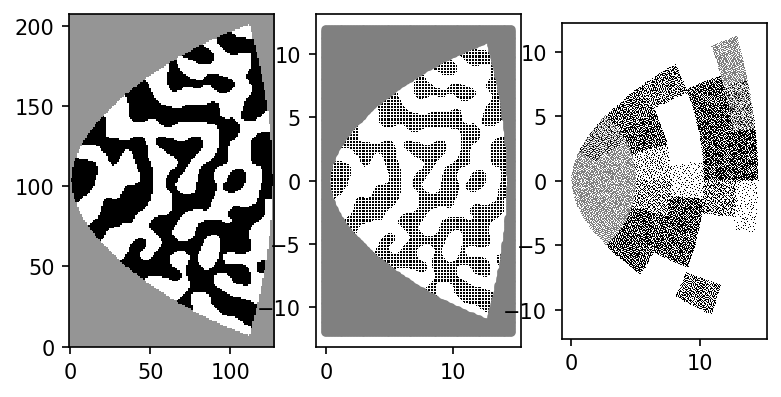

In [7]:
fig = plt.figure('LR',dpi=150)

ax = fig.add_subplot(131)
ax.imshow(LR,cmap='Greys', origin = 'lower')

ax = fig.add_subplot(132)
xx, yy = np.meshgrid(x,y)
ax.plot(xx[LR>0],yy[LR>0],',k')
ax.plot(xx[LR<0],yy[LR<0],',w')
ax.plot(xx[LR==0],yy[LR==0],'.',c='0.5')
ax.set_aspect('equal')

ax = fig.add_subplot(133)
for i in range(nblock):
    ax.plot(pos[i,0,:],pos[i,1,:],',')
    
#label = find_neuron_in_OD(LR,Pi,pos,xx,yy,blockSize)
label = find_OD_in_neuron(LR,Pi,pos,x,y,blockSize)

ax.plot(pos[:,0,:][label<0],pos[:,1,:][label<0],',w')
ax.plot(pos[:,0,:][label>0],pos[:,1,:][label>0],',k')
ax.plot(pos[:,0,:][label==0],pos[:,1,:][label==0],',',c='0.5')
ax.set_aspect('equal')

In [24]:
pos[:,0,:].shape

(32, 1024)